# SP simulations examining time-varying flow

In this notebook, we simulate the response where we have time-varying flow for wellbore geometry 2 from [1-plug-and-abandonment-steady-state.ipynb](1-plug-and-abandonment-steady-state.ipynb)

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize, SymLogNorm
from matplotlib import cm as colormap
from scipy.constants import foot, inch
from scipy.interpolate import interp1d
import pandas as pd

import discretize
from discretize import utils
from simpeg.electromagnetics import frequency_domain as fdem
from simpeg import utils, maps, Report
import geoana

from pymatsolver import Pardiso

## Set up the model parameters

- all conductivity values are in units of S/m
- all length scales are in units of meters

To ignore steel, change the conductivity value of the steel to be the same as the background. 

In [2]:
conductivity_values = {
    "background":0.07,
    "cement":0.01,
    "cement_eap": 85, 
    "sand": 0.01,
    "steel": 0.07, # 5e6, 
    "very_resistive":1e-8,
    "fluid":0.05,
    "break": 0.01,
}

print("Conductivity values")
for key, val in conductivity_values.items():
    print(f"{key:15s}: {val:1.1e} S/m")


Conductivity values
background     : 7.0e-02 S/m
cement         : 1.0e-02 S/m
cement_eap     : 8.5e+01 S/m
sand           : 1.0e-02 S/m
steel          : 7.0e-02 S/m
very_resistive : 1.0e-08 S/m
fluid          : 5.0e-02 S/m
break          : 1.0e-02 S/m


In [3]:
geometry = {
    "casing_length": 34, # 122ft - 10ft packer@ bottom = 112ft
    "surface_packer_thickness": 0.5, # 1.6ft
    "bottom_seal_thickness": 3,  # 10ft
    "casing_outer_diameter": 0.2, #0.6, #0.2, # 7.75in
    "casing_inner_diameter": 0.18, # 7in
    "pvc_outer_diameter": 0.04, # 1.5in
    "pvc_inner_diameter": 0.03, # 1.0in
    "break_top": 0, 
    "break_bottom": -2,
}
geometry["casing_outer_radius"] = geometry["casing_outer_diameter"] / 2
geometry["casing_inner_radius"] = geometry["casing_inner_diameter"] / 2
geometry["pvc_outer_radius"] = geometry["pvc_outer_diameter"] / 2
geometry["pvc_inner_radius"] = geometry["pvc_inner_diameter"] / 2
geometry["total_length"] = geometry["casing_length"] + geometry["bottom_seal_thickness"]

cement_depth = {
    # "case_1": 15, # 50 ft
    "case_2": 30, # 100 ft
    # "case_3": 7.5, # 25ft
}

print("Geometry")
for key, val in geometry.items():
    print(f"{key:25s}: {val:3.2f} m")
print("\nCement depth")
for key, val in cement_depth.items():
    print(f"{key:8s}: {val:2.1f} m")

Geometry
casing_length            : 34.00 m
surface_packer_thickness : 0.50 m
bottom_seal_thickness    : 3.00 m
casing_outer_diameter    : 0.20 m
casing_inner_diameter    : 0.18 m
pvc_outer_diameter       : 0.04 m
pvc_inner_diameter       : 0.03 m
break_top                : 0.00 m
break_bottom             : -2.00 m
casing_outer_radius      : 0.10 m
casing_inner_radius      : 0.09 m
pvc_outer_radius         : 0.02 m
pvc_inner_radius         : 0.01 m
total_length             : 37.00 m

Cement depth
case_2  : 30.0 m


## compute Jsp for time varying flow

pore pressure gradient values are provided in the file [pore-pressure-gradient.csv](pore-pressure-gradient.csv)

In [38]:
rho_water = 1000
g = 10 
L = 1e-5

In [39]:
pore_pressure_grad_data = pd.read_csv("pore-pressure-gradient.csv")
pore_pressure_grad_data.iloc[0, 1:] = 0
pore_pressure_grad_data

,Depth (m),"Grad. P (Pa/m), t=1 s","Grad. P (Pa/m), t=5 s","Grad. P (Pa/m), t=10 s","Grad. P (Pa/m), t=30 s","Grad. P (Pa/m), t=60 s","Grad. P (Pa/m), t=120 s"
0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
1,2.00,0.0,0.0,0.0,0.0,-49400000.0,-2280000.0
2,4.00,0.0,0.0,0.0,0.0,-23600000.0,-1580000.0
3,6.00,0.0,0.0,0.0,0.0,-11900000.0,-1120000.0
4,8.00,0.0,0.0,0.0,0.0,-6320000.0,-816000.0
5,10.00,0.0,0.0,0.0,0.0,-3540000.0,-611000.0
6,12.00,0.0,0.0,0.0,-29500000.0,-2100000.0,-470000.0
7,14.00,0.0,0.0,0.0,-11500000.0,-1310000.0,-372000.0
8,16.00,0.0,0.0,0.0,-5010000.0,-864000.0,-302000.0
9,18.00,0.0,0.0,0.0,-2420000.0,-601000.0,-252000.0


In [40]:
pore_pressure_cols = pore_pressure_grad_data.columns[1:]
depths = pore_pressure_grad_data["Depth (m)"].to_numpy()

In [41]:
pore_pressure_cols.to_list()

['Grad. P (Pa/m), t=1 s',
 'Grad. P (Pa/m), t=5 s',
 'Grad. P (Pa/m), t=10 s',
 'Grad. P (Pa/m), t=30 s',
 'Grad. P (Pa/m), t=60 s',
 'Grad. P (Pa/m), t=120 s']

In [42]:
scaling = - L / (rho_water * g) 
scaling

-1e-09

## set up interpolation functions to interpolate to the mesh

In [10]:
depths_interp = {}
interp_dict = {}
for key in pore_pressure_cols.to_list():
    grad_p = pore_pressure_grad_data[key].to_numpy()
    non_zero_inds = np.abs(grad_p) > 0
    depths_interp[key] = depths[non_zero_inds]
    interp_dict[key] = interp1d(
            depths[non_zero_inds], np.log(scaling * grad_p[non_zero_inds]), 
            fill_value=0, kind="linear", bounds_error=False
        ) 
interp_dict

{'Grad. P (Pa/m), t=1 s': <scipy.interpolate._interpolate.interp1d at 0x7f9514a45ea0>,
 'Grad. P (Pa/m), t=5 s': <scipy.interpolate._interpolate.interp1d at 0x7f9514a49090>,
 'Grad. P (Pa/m), t=10 s': <scipy.interpolate._interpolate.interp1d at 0x7f9514a49220>,
 'Grad. P (Pa/m), t=30 s': <scipy.interpolate._interpolate.interp1d at 0x7f9514a493b0>,
 'Grad. P (Pa/m), t=60 s': <scipy.interpolate._interpolate.interp1d at 0x7f9514a49540>,
 'Grad. P (Pa/m), t=120 s': <scipy.interpolate._interpolate.interp1d at 0x7f9514a496d0>}

# build a mesh

- we highly refine the mesh near the wellbore and then pad out to ensure that we satisfy boundary conditions (e.g. that the outer boundary is a few skin depths away)

In [43]:
csx = 0.0025
csz = 0.125
padding_factor = 1.1
npad_x = 120 
npad_z = 80 

n_core_x = int(np.ceil(geometry["casing_outer_radius"]/csx))
n_core_z = int(np.ceil((geometry["total_length"])/csz))

In [44]:
mesh = discretize.CylindricalMesh(
    [
        [(csx, n_core_x), (csx, npad_x, padding_factor)],
        np.r_[2*np.pi], 
        [(csz, npad_z, -padding_factor), (csz, n_core_z), (csz, npad_z, padding_factor)]
    ]
)

mesh.origin = np.r_[0, 0, -mesh.h[2][:npad_z+n_core_z].sum()]

<AxesSubplot:xlabel='x', ylabel='z'>

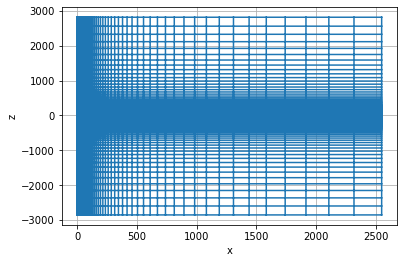

In [45]:
mesh.plot_grid()

In [46]:
print(mesh.n_cells)

72960


## interpolate jsp values to the mesh

In [47]:
jsp_vertical = {}
for key in pore_pressure_cols:
    jsp = np.zeros_like(mesh.nodes_z)
    inds_nonzero = (mesh.nodes_z > -30) & (mesh.nodes_z < -depths_interp[key].min())
    
    jsp[inds_nonzero] = np.exp(interp_dict[key](-mesh.nodes_z[inds_nonzero]))
    jsp_vertical[key] = jsp

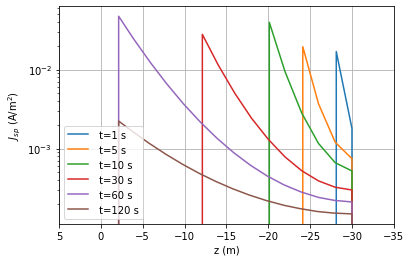

In [48]:
fig, ax = plt.subplots(1, 1)

for key in pore_pressure_cols:
    ax.semilogy(mesh.nodes_z, jsp_vertical[key], label=key.split(",")[-1])
ax.set_xlim([5, -35])
# ax.set_ylim([1e-4, 1e-1])
ax.set_xlabel("z (m)")
ax.set_ylabel("$J_{sp}$ (A/m$^2$)") 
ax.grid()
ax.legend()   

## put the model on the mesh

In [50]:
def get_model(case, eap=False, steel_conductivity=None, broken_casing=False): 
    """
    A function to put the electrical conductivity model on the mesh for each 
    of the different cases. 
    """
    
    if steel_conductivity is None: 
        steel_conductivity = conductivity_values["steel"]
    
    # initialize as background
    model = np.ones(mesh.n_cells) * conductivity_values["background"]

    # air
    model[mesh.cell_centers[:,2] > 0] = conductivity_values["very_resistive"]

    # steel casing
    inds_casing_z = (
        (mesh.cell_centers[:, 2] >= -geometry["casing_length"]) &
        (mesh.cell_centers[:, 2] <= 0)
    )
    inds_steel = (
        (mesh.cell_centers[:, 0] <= geometry["casing_outer_radius"]) & 
        (mesh.cell_centers[:, 0] >= geometry["casing_inner_radius"]) &
        inds_casing_z
    )
    
    model[inds_steel] = steel_conductivity 

    # sand and cement 
    inds_x_cement = (mesh.cell_centers[:, 0] < geometry["casing_inner_radius"])
    inds_z_cement = (
        (mesh.cell_centers[:, 2] < 0) & 
        (mesh.cell_centers[:, 2] >= -cement_depth[case])
    )

    model[inds_x_cement & inds_casing_z] = conductivity_values["sand"]

    if eap is False: 
        model[inds_x_cement & inds_z_cement] = conductivity_values["cement"]
    elif eap is True:
        model[inds_x_cement & inds_z_cement] = conductivity_values["cement_eap"]

    # surface_packer 
    inds_surface_packer = (
        inds_x_cement & 
        (mesh.cell_centers[:, 2] < 0) & 
        (mesh.cell_centers[:, 2] >= -geometry["surface_packer_thickness"])
    )
    model[inds_surface_packer] = conductivity_values["very_resistive"]

    # pvc casing
    inds_pvc = (
        (mesh.cell_centers[:, 0] <= geometry["pvc_outer_radius"]) &
        inds_casing_z 
    )
    model[inds_pvc] = conductivity_values["very_resistive"]

    # fluid
    inds_fluid = (
        (mesh.cell_centers[:, 0] <= geometry["pvc_inner_radius"]) &
        inds_casing_z 
    )
    model[inds_fluid] = conductivity_values["fluid"]

    # bottom hole packer
    inds_bottom_packer = (
        (mesh.cell_centers[:, 0] < geometry["casing_outer_radius"]) & 
        (mesh.cell_centers[:, 2] >= -geometry["total_length"]) & 
        (mesh.cell_centers[:, 2] <= - geometry["casing_length"])
    )
    model[inds_bottom_packer] = conductivity_values["very_resistive"]

    return model

## create dictionaries to hold the various models

In [56]:
models_cement = {key: get_model(key, False) for key in cement_depth.keys()}
models_cement_eap = {key: get_model(key, True) for key in cement_depth.keys()}

model_wholespace = conductivity_values["background"] * np.ones(mesh.n_cells)
model_halfspace = model_wholespace.copy()
model_halfspace[mesh.cell_centers[:, 2] > 0] = conductivity_values["very_resistive"]

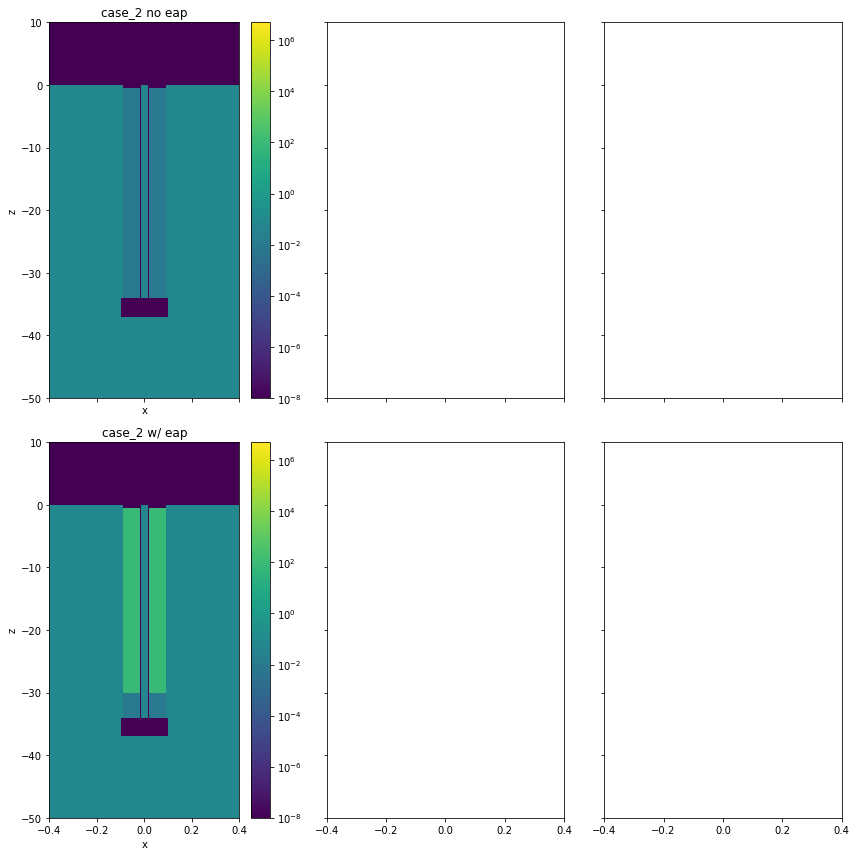

In [57]:
fig, ax = plt.subplots(2, 3, figsize=(12, 12), sharex=True, sharey=True)

xlim = 0.4 * np.r_[-1, 1]
ylim = np.r_[-50, 10]

vmin = conductivity_values["very_resistive"]
vmax = 5e6 # conductivity_values["steel"]

plotme = (models_cement, models_cement_eap)

for i, key in enumerate(list(models_cement.keys())): 
    for j, m in enumerate([plotme[i][key], plotme[i+1][key]]): 
        cb = plt.colorbar(
            mesh.plot_image(
                m, ax=ax[j, i], mirror=True, pcolor_opts={"norm":LogNorm(vmin=vmin, vmax=vmax)}
            )[0], ax=ax[j, i]
        )
        if i == 2: 
            cb.set_label("conductivity (S/m)")
        if j == 0: 
            ax[0, i].set_title(key + " no eap")
        elif j == 1: 
            ax[1, i].set_title(key + " w/ eap")
   

for a in ax.flatten(): 
    a.set_xlim(xlim)
    a.set_ylim(ylim)
plt.tight_layout()

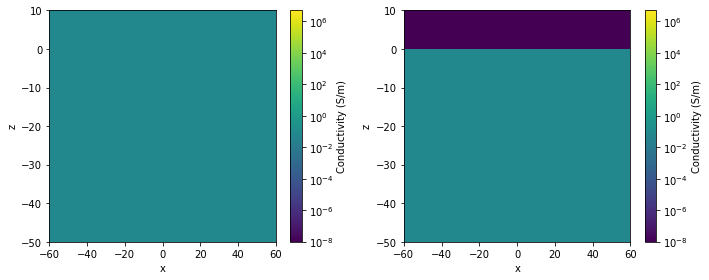

In [58]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

xlim = 60* np.r_[-1, 1]
ylim = np.r_[-50, 10]
 
for j, m in enumerate([model_wholespace, model_halfspace]): 
    cb = plt.colorbar(
        mesh.plot_image(
            m, ax=ax[j], mirror=True, pcolor_opts={"norm":LogNorm(vmin=vmin, vmax=vmax)}
        )[0], ax=ax[j]
    )
    cb.set_label("Conductivity (S/m)")
# ax[0, i].set_title(key)

for a in ax.flatten(): 
    a.set_xlim(xlim)
    a.set_ylim(ylim)
plt.tight_layout()

In [54]:
case = "case_2"
def get_jsp(key): 
    jsp_z = np.zeros(mesh.n_faces_z)
    inds_jsp = (
        (mesh.faces_z[:, 0] > geometry["pvc_outer_radius"]) & 
        (mesh.faces_z[:, 0] < geometry["casing_inner_radius"]) &
        (mesh.faces_z[:, 2] < -geometry["surface_packer_thickness"]) &
        (mesh.faces_z[:, 2] > -cement_depth[case]) 
    )
    jsp_z[inds_jsp] = interp_dict[key](-mesh.faces_z[inds_jsp, 2])
    return np.r_[np.zeros(mesh.n_faces_x), jsp_z]


In [55]:
jsp = {key: get_jsp(key) for key in pore_pressure_cols} 

## set up the simulations

Here, we use a frequency of 0.1Hz

In [59]:
freq = 1e-1

def get_sim(case):
    src = fdem.sources.RawVec_e([], frequency=freq, s_e=jsp[case])
    survey = fdem.survey.Survey([src])
    return fdem.simulation.Simulation3DMagneticField(
        mesh, survey=survey, sigmaMap=maps.IdentityMap(mesh), solver=Pardiso
    )

simulations = {key: get_sim(key) for key in pore_pressure_cols}

### run the simulations

In [60]:
fields_cement = {}
fields_cement_eap = {}

fields_wholespace = {}
fields_halfspace = {}

key="case_2"
for case, sim in simulations.items(): 
    fields_cement[case] = sim.fields(models_cement[key])
    fields_cement_eap[case] = sim.fields(models_cement_eap[key])
    
    fields_wholespace[case] = sim.fields(model_wholespace)
    fields_halfspace[case] = sim.fields(model_halfspace)

### measure radial electric field data at the surface

In [26]:
dx = 2
surface_ex_inds = (
    (mesh.faces_x[:, 2] < 0) & (mesh.faces_x[:, 2] > -csz) & 
    (mesh.faces_x[:, 0] > dx)
)

surface_e_inds = np.r_[surface_ex_inds, np.zeros(mesh.n_faces_z, dtype=bool)]
x_data = mesh.nodes_x[mesh.nodes_x > dx]

In [62]:
# analytic solutions for wholespace 

def get_wholespace_solution(key): 
    inds_dipole = (
        (mesh.faces_z[:, 0] < csx) &
        (mesh.faces_z[:, 2] < -geometry["surface_packer_thickness"]) &
        (mesh.faces_z[:, 2] > -cement_depth["case_2"])
    )
    
    dipole_locations = np.c_[np.zeros(inds_dipole.sum()), np.zeros(inds_dipole.sum()), mesh.faces_z[inds_dipole, 2]]
    
    e_analytic = np.zeros_like(x_data, dtype=complex)
    area = np.pi * (geometry['casing_inner_radius']**2  - geometry['pvc_outer_radius']**2)
    for i in range(dipole_locations.shape[0]):
        edipole = geoana.em.fdem.ElectricDipoleWholeSpace(
            frequency=freq, location=dipole_locations[i, :], length=csz, current=interp_dict[key](-dipole_locations[i, 2])*area, 
            orientation="Z", sigma=conductivity_values["background"]
        )
        e_analytic = edipole.electric_field(np.c_[x_data, np.zeros_like(x_data), -csz/2*np.ones_like(x_data)])[:, 0] + e_analytic
    return e_analytic

In [63]:
e_analytic_wholespace = {
    key: get_wholespace_solution(key) for key in pore_pressure_cols
}

# plot results

Text(0.5, 1.0, 'Wholespace solutions')

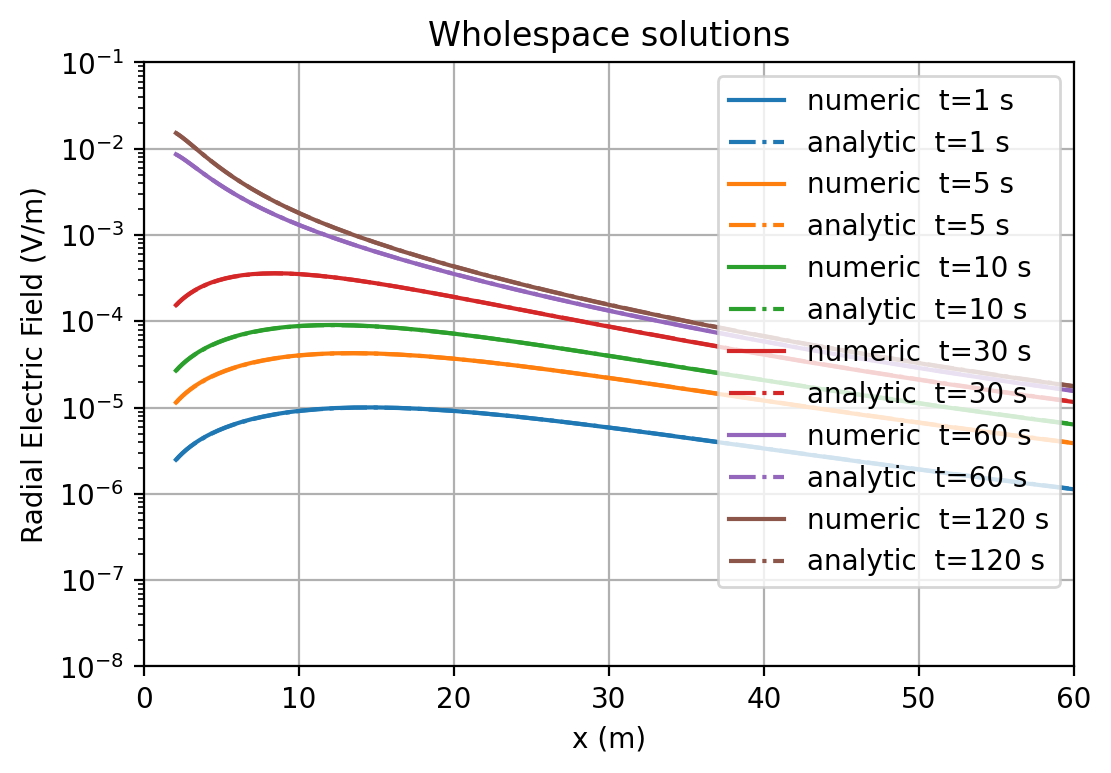

In [64]:
fig, ax = plt.subplots(1, 1, dpi=200)

xlim = np.r_[0, 60]
ylim = np.r_[1e-8, 1e-1]

for i, key in enumerate(e_analytic_wholespace.keys()):
    numeric = -fields_wholespace[key][:, "e"][surface_e_inds].flatten()
    analytic = -e_analytic_wholespace[key]
    ax.semilogy(x_data, numeric.real, color=f"C{i}", label=f"numeric {key.split(',')[-1]}")
    ax.semilogy(x_data, analytic.real, "-.", color=f"C{i}", label=f"analytic {key.split(',')[-1]}")
    # ax.semilogy(x_data, (analytic.real - numeric.real), ":", color=f"C{i}", label=f"difference {key}")

ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xlabel("x (m)")
ax.set_ylabel("Radial Electric Field (V/m)")
ax.grid()
ax.legend()
ax.set_title("Wholespace solutions")


Text(0.5, 1.0, 'Wholespace solutions')

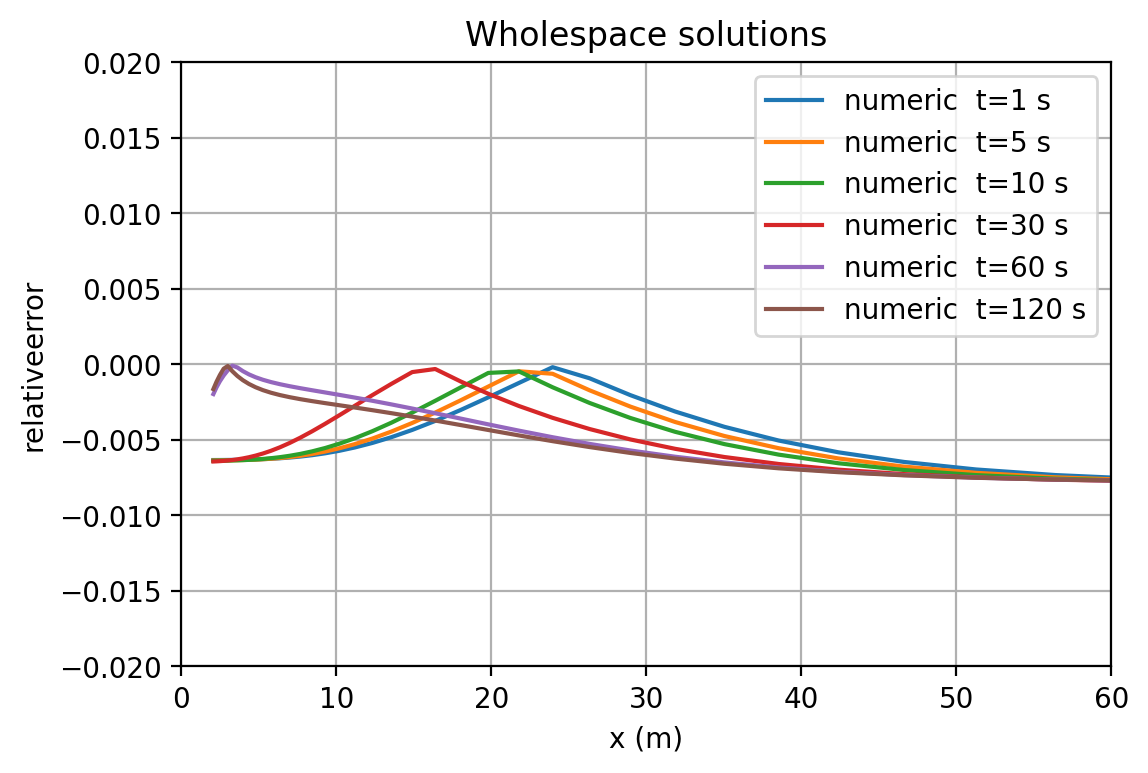

In [65]:
fig, ax = plt.subplots(1, 1, dpi=200)

xlim = np.r_[0, 60]
ylim = np.r_[1e-8, 9e-4]

for i, key in enumerate(e_analytic_wholespace.keys()):
    numeric = fields_wholespace[key][:, "e"][surface_e_inds].flatten()
    analytic = e_analytic_wholespace[key]
    ax.plot(x_data, np.abs(numeric.real-analytic.real)/analytic.real, color=f"C{i}", label=f"numeric {key.split(',')[-1]}")
ax.set_xlim(xlim)
ax.set_ylim([-0.02, 0.02])
ax.set_xlabel("x (m)")
ax.set_ylabel("relativeerror")
ax.grid()
ax.legend()
ax.set_title("Wholespace solutions")


Text(0.5, 1.0, 'Halfspace solutions')

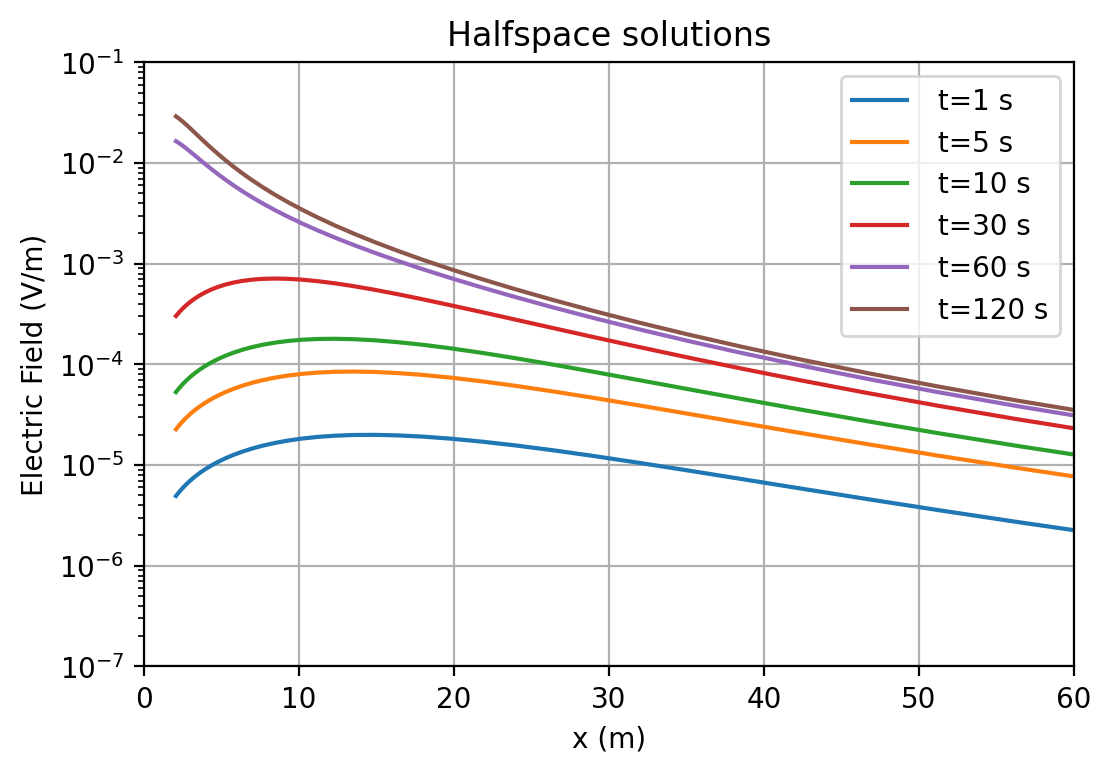

In [66]:
fig, ax = plt.subplots(1, 1, dpi=200)

xlim = np.r_[0, 60]
ylim = np.r_[1e-7, 1e-1]

for i, key in enumerate(fields_halfspace.keys()):
    numeric = fields_halfspace[key][:, "e"][surface_e_inds].flatten()
    ax.semilogy(x_data, -numeric.real, color=f"C{i}", label=f"{key.split(',')[-1]}")

ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xlabel("x (m)")
ax.set_ylabel("Electric Field (V/m)")
ax.grid()
ax.legend()
ax.set_title("Halfspace solutions")

Text(0.5, 1.0, 'Casing models (7e-02 S/m)')

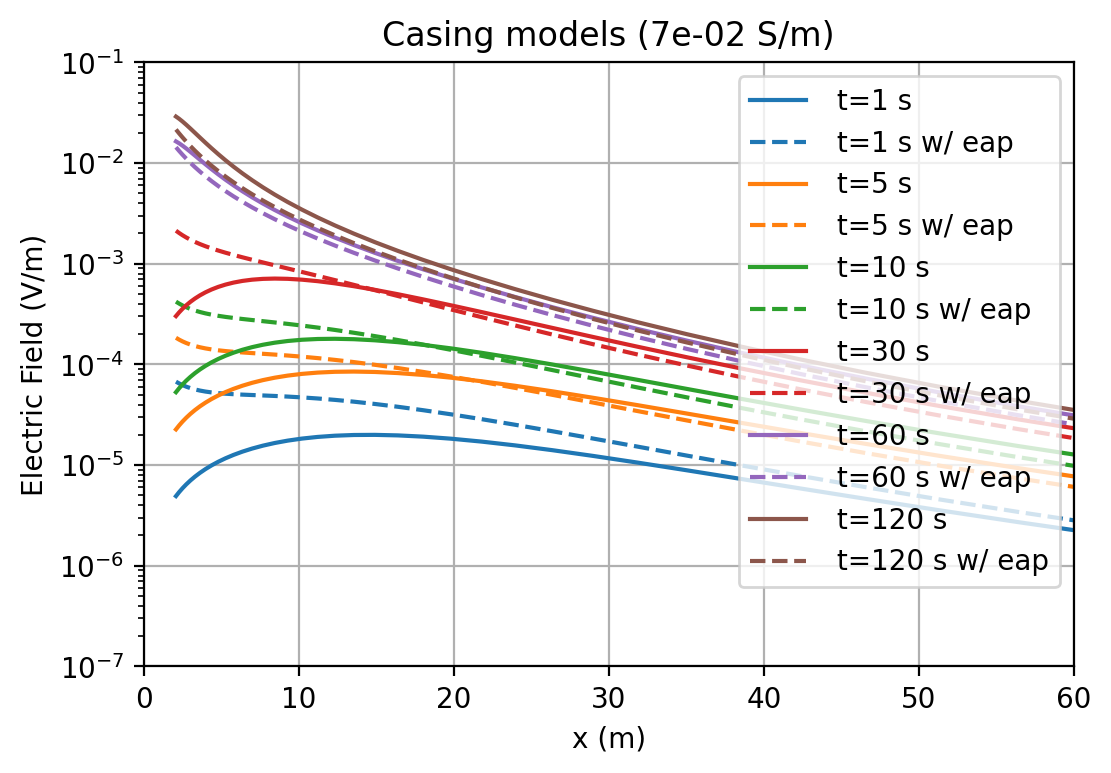

In [67]:
fig, ax = plt.subplots(1, 1, dpi=200)

xlim = np.r_[0, 60]
ylim = np.r_[1e-7, 1e-1]

i = 0
for key, val in fields_cement.items():
    ax.semilogy(x_data, np.abs(fields_cement[key][:, "e"][surface_e_inds].real), color=f"C{i}", label=f"{key.split(',')[-1]}")
    ax.semilogy(x_data, np.abs(fields_cement_eap[key][:, "e"][surface_e_inds].real), "--", color=f"C{i}", label=f"{key.split(',')[-1]} w/ eap")
    i = i+1

ax.legend()
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xlabel("x (m)")
ax.set_ylabel("Electric Field (V/m)")
ax.grid()
ax.set_title(f"Casing models ({conductivity_values['steel']:1.0e} S/m)")